Read CSV data with Pandas.

In [85]:
import pandas as pd

# load final df, game season and stats previous season align
final_df = pd.read_csv('nba_data/nba_df_final.csv')

Reduce size of dataset to that of parent paper.

In [86]:
final_df = final_df[(final_df['SEASON'] >= 2018) & (final_df['SEASON'] <= 2021)]
# final_df

Prepare data for feature reduction and machine learning.

In [87]:
X = final_df.drop(columns=['GAME_DATE_EST',
 'GAME_ID',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'HOME_TEAM_WINS',
 'H_Team_Elo_After',
 'A_Team_Elo_After',
 'PTS_home',
 'PTS_away'])

X = X.fillna(X.mean())
y = final_df['HOME_TEAM_WINS']

# X.head()

Apply machine learning algorithms to datasets.

In [88]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from joblib import parallel_backend

models = [
        ('LogReg', LogisticRegression(max_iter=10000)),
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC()),
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('MLP', MLPClassifier(max_iter=10000))
    ]

def run_exps(X_train, X_test, y_train, y_test):
    vdfs = []
    tdfs = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    target_names = ['win', 'loss']
    
    for name, model in models:
        with parallel_backend('threading', n_jobs=-1):
            kfold = KFold(n_splits=5, shuffle=True, random_state=90210)
            cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
        
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            cr = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
        
        d = cr['weighted avg']
        for key in d:
            d[key] = [d[key]]
        d['accuracy'] = [cr['accuracy']]
        this_df = pd.DataFrame(d)
        this_df['model'] = name
        tdfs.append(this_df)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        vdfs.append(this_df)
    
    vresults = pd.concat(vdfs, ignore_index=True)
    tresults = pd.concat(tdfs, ignore_index=True)

    return vresults, tresults

Perform feature reduction.

In [90]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import Parallel, delayed

def process_subset_pca(X, y, pca_ratio):
    # Apply PCA
    pca = PCA(n_components=pca_ratio)  
    X_pca = pca.fit_transform(X)

    # # Display how many components are selected
    # print(f"PCA (ratio={pca_ratio}) reduced the features to {X_pca.shape[1]} components.")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)
    
    # Run experiments with the processed dataset
    return run_exps(X_train, X_test, y_train, y_test), pca_ratio, X_pca.shape[1]


def process_subset_select(X, y, select_ratio):
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    n_features = int(select_ratio*X.shape[1])

    # Apply feature selection
    selector = SelectKBest(score_func=f_classif, k=n_features)
    selector.fit(X_train, y_train)

    X_train_select = selector.transform(X_train)
    X_test_select = selector.transform(X_test)

    # Get the indices of the selected features
    select_indices = selector.get_support(indices=True)
    
    # # Display how many components are selected
    # print(f"Select {100*select_ratio}% of features, reducing to {n_features} features.")
    
    # Run experiments with the processed dataset
    return run_exps(X_train_select, X_test_select, y_train, y_test), select_ratio, n_features, select_indices

In [91]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

c:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_bar_graph(method, ratio, df):
    # Melt the DataFrame to long format
    df_melted = df.melt(id_vars='model', var_name='metric', value_name='values')
    
    title_metric = f'Comparison of Model by Classification Metric, {method} Ratio {ratio}'
    sns.set_theme(font_scale=2.5)
    plt.figure(figsize=(20, 12))
    sns.barplot(data=df_melted, x='model', y='values', hue='metric').set_ylim(0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_metric)
    plt.savefig(f'plots/{method}_{ratio}_test.png',dpi=300)
    plt.show()


In [102]:
# train models with pca dimension reduction dataset
pca_ratios = [0.8, 0.90, 0.95]
pca_results = Parallel(n_jobs=-1)(
    delayed(process_subset_pca)(X_scaled, y, ratio) for ratio in pca_ratios
)

Validation results with PCA ratio of 0.8, 15 components


,model,fit_time,score_time,valid_accuracy,valid_precision_weighted,valid_recall_weighted,valid_f1_weighted
0,GNB,0.007625,0.020891,0.607549,0.602706,0.607549,0.591443
1,KNN,0.017089,0.169205,0.591975,0.588049,0.591975,0.588461
2,LogReg,0.026508,0.020690,0.605675,0.599883,0.605675,0.591108
3,MLP,22.857773,0.013254,0.577657,0.575665,0.577657,0.575824
4,RF,0.886569,0.101615,0.589480,0.584425,0.589480,0.583806
5,SVM,0.349251,0.159717,0.617806,0.613582,0.617806,0.604720
6,XGB,0.304808,0.015391,0.581085,0.577277,0.581085,0.577570


Test results with PCA ratio of 0.8, 15 components


,test_precision_weighted,test_recall_weighted,test_f1-score_weighted,support,test_accuracy,model
0,0.573391,0.581699,0.566072,1071,0.581699,LogReg
1,0.605956,0.609711,0.606034,1071,0.609711,RF
2,0.586166,0.588235,0.586881,1071,0.588235,KNN
3,0.613959,0.618114,0.606091,1071,0.618114,SVM
4,0.570311,0.578898,0.563679,1071,0.578898,GNB
5,0.583577,0.585434,0.584260,1071,0.585434,XGB
6,0.609051,0.612512,0.609273,1071,0.612512,MLP


c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

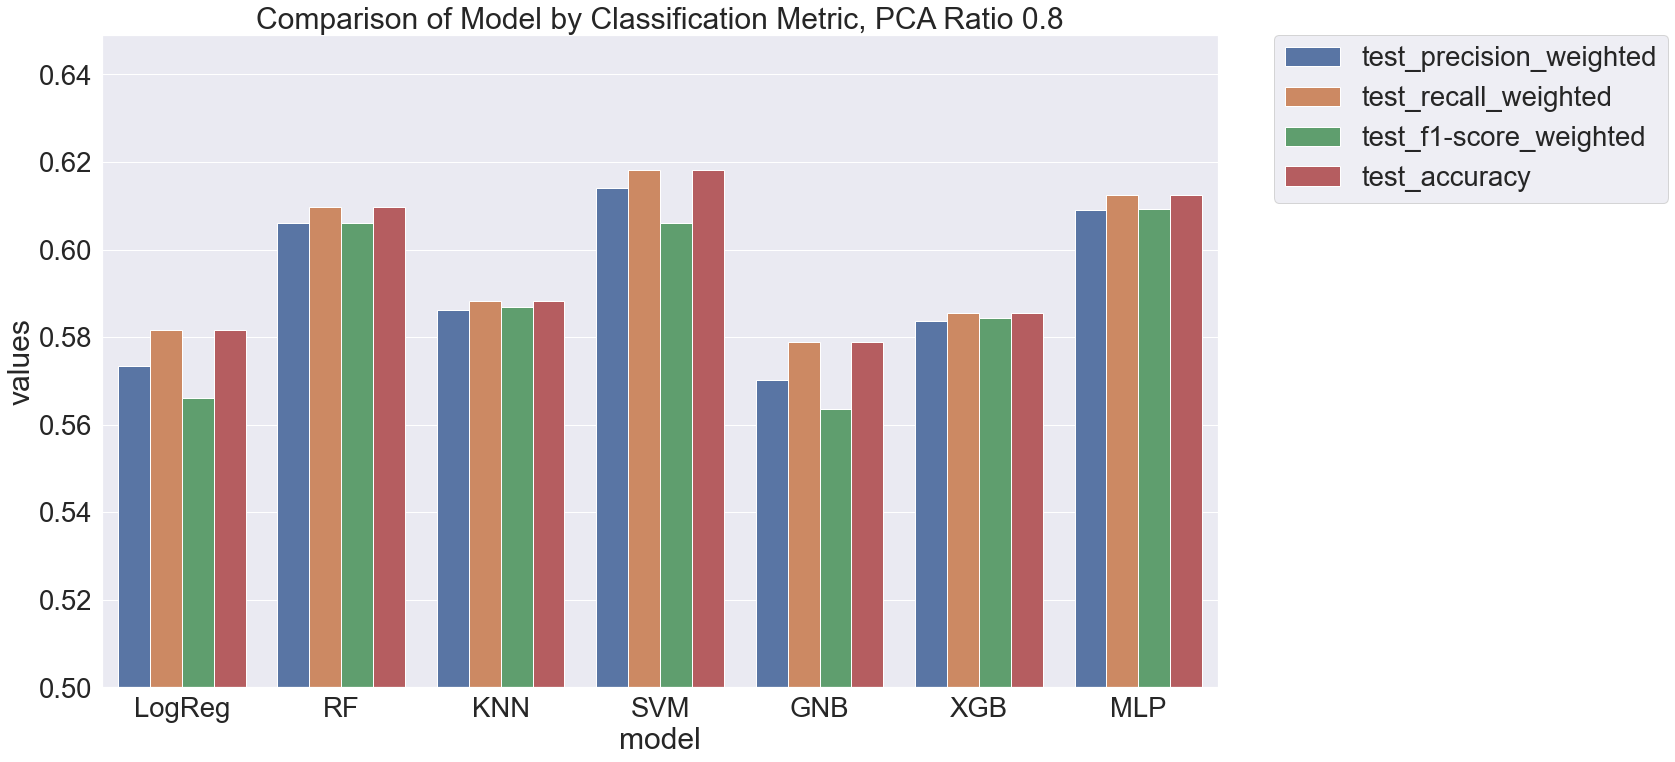

Validation results with PCA ratio of 0.9, 23 components


,model,fit_time,score_time,valid_accuracy,valid_precision_weighted,valid_recall_weighted,valid_f1_weighted
0,GNB,0.006186,0.021668,0.637420,0.633912,0.637420,0.630773
1,KNN,0.005722,0.263145,0.595404,0.592725,0.595404,0.592929
2,LogReg,0.039371,0.021488,0.635238,0.632043,0.635238,0.628577
3,MLP,25.697993,0.010473,0.584190,0.583273,0.584190,0.583528
4,RF,1.056977,0.109599,0.608155,0.604053,0.608155,0.603055
5,SVM,0.289500,0.148613,0.630566,0.627381,0.630566,0.620482
6,XGB,0.398579,0.004866,0.588237,0.584801,0.588237,0.584444


Test results with PCA ratio of 0.9, 23 components


,test_precision_weighted,test_recall_weighted,test_f1-score_weighted,support,test_accuracy,model
0,0.590947,0.596639,0.588923,1071,0.596639,LogReg
1,0.610960,0.614379,0.611156,1071,0.614379,RF
2,0.597817,0.601307,0.598300,1071,0.601307,KNN
3,0.626657,0.630252,0.621580,1071,0.630252,SVM
4,0.592866,0.598506,0.590588,1071,0.598506,GNB
5,0.591759,0.595705,0.592156,1071,0.595705,XGB
6,0.588304,0.589169,0.588685,1071,0.589169,MLP


c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

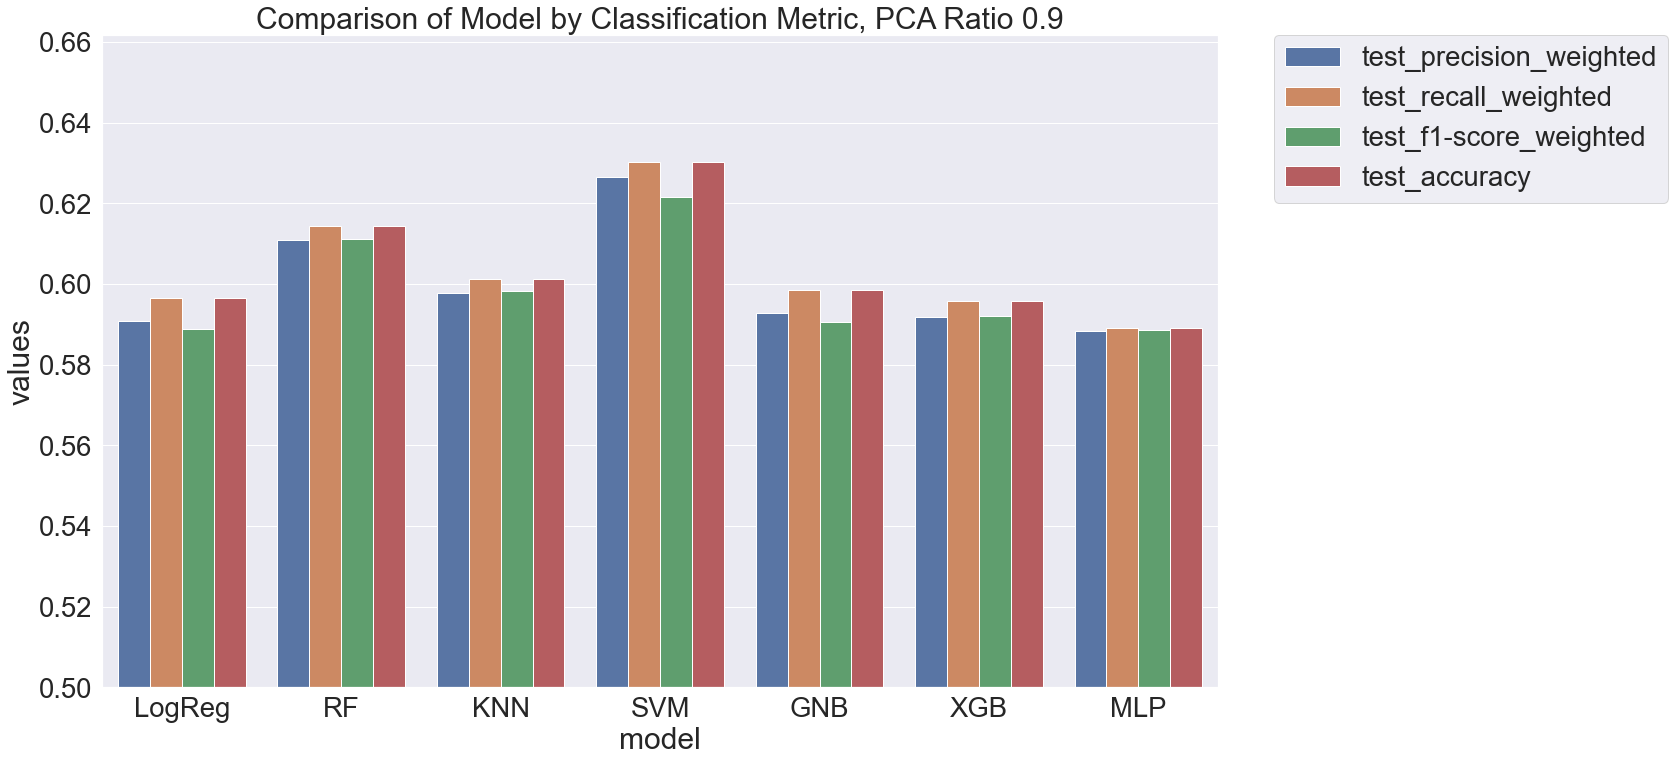

Validation results with PCA ratio of 0.95, 30 components


,model,fit_time,score_time,valid_accuracy,valid_precision_weighted,valid_recall_weighted,valid_f1_weighted
0,GNB,0.006462,0.020784,0.633999,0.630843,0.633999,0.627132
1,KNN,0.005237,0.211769,0.591974,0.588988,0.591974,0.589340
2,LogReg,0.054124,0.027201,0.637729,0.634372,0.637729,0.631583
3,MLP,22.818446,0.009975,0.581390,0.579524,0.581390,0.580129
4,RF,1.168085,0.062269,0.606286,0.601427,0.606286,0.600251
5,SVM,0.269510,0.112772,0.632120,0.628756,0.632120,0.623304
6,XGB,0.575311,0.006546,0.590727,0.587492,0.590727,0.587510


Test results with PCA ratio of 0.95, 30 components


,test_precision_weighted,test_recall_weighted,test_f1-score_weighted,support,test_accuracy,model
0,0.591285,0.596639,0.590068,1071,0.596639,LogReg
1,0.614022,0.618114,0.612995,1071,0.618114,RF
2,0.601960,0.605042,0.602524,1071,0.605042,KNN
3,0.629603,0.633053,0.624800,1071,0.633053,SVM
4,0.590058,0.595705,0.588324,1071,0.595705,GNB
5,0.597930,0.601307,0.598458,1071,0.601307,XGB
6,0.595313,0.596639,0.595843,1071,0.596639,MLP


c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

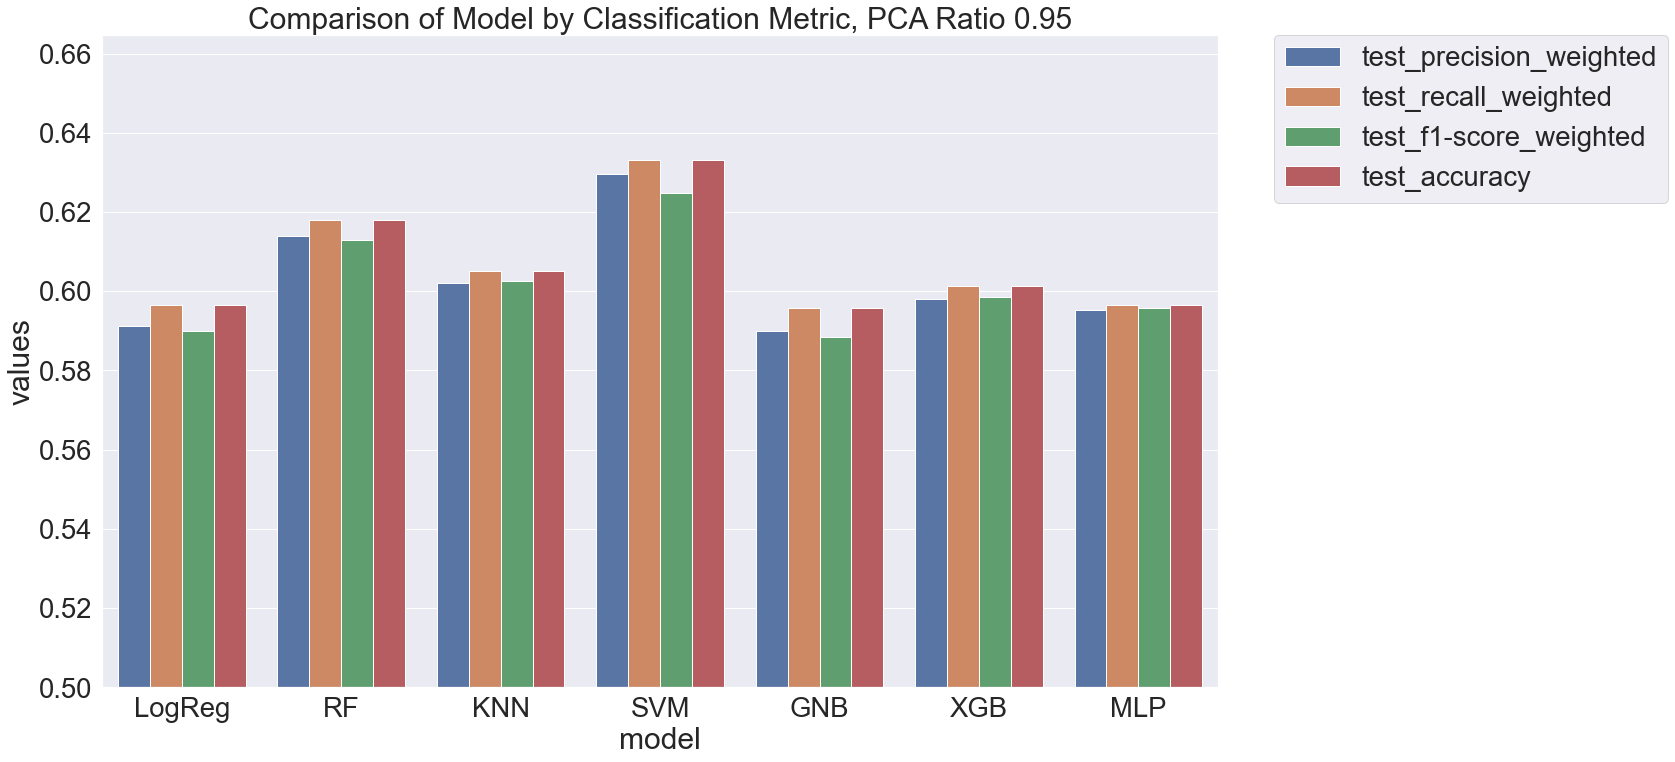

In [105]:
for result in pca_results:
    vdf, tdf, pca_ratio, n_components = result[0][0], result[0][1], result[1], result[2]
    print(f'Validation results with PCA ratio of {pca_ratio}, {n_components} components')
    vdf.columns = [col.replace('test_', 'valid_') if col.startswith('test_') else col for col in vdf.columns]
    display(vdf.groupby('model').mean().reset_index())
    
    print(f'Test results with PCA ratio of {pca_ratio}, {n_components} components')
    for col in ['precision','recall','f1-score']:
        if col in tdf.columns:
            tdf.rename(columns={col: 'test_' + col + '_weighted'}, inplace=True)
    tdf.rename(columns={'accuracy': 'test_accuracy'}, inplace=True)
    display(tdf)

    generate_bar_graph('PCA',pca_ratio,tdf.drop(columns=['support']))

In [106]:
# train models with selectkbest feature selection dataset
select_ratios = [0.5, 0.25, .1]
select_results = Parallel(n_jobs=-1)(
    delayed(process_subset_select)(X_scaled, y, ratio) for ratio in select_ratios
)

Selected features: Index(['h_age', 'h_w', 'h_l', 'h_pw', 'h_pl', 'h_mov', 'h_srs', 'h_d_rtg',
       'h_n_rtg', 'h_f_tr', 'h_ts_percent', 'h_e_fg_percent', 'h_tov_percent',
       'h_ft_fga', 'h_opp_e_fg_percent', 'h_opp_ft_fga', 'h_fga_per_100_poss',
       'h_fg_percent', 'h_x2p_percent', 'h_ft_per_100_poss',
       'h_fta_per_100_poss', 'h_ast_per_100_poss', 'h_tov_per_100_poss',
       'h_pf_per_100_poss', 'h_team_eff_ind', 'a_age', 'a_w', 'a_l', 'a_pw',
       'a_pl', 'a_mov', 'a_srs', 'a_d_rtg', 'a_n_rtg', 'a_f_tr',
       'a_ts_percent', 'a_e_fg_percent', 'a_opp_e_fg_percent',
       'a_opp_drb_percent', 'a_fga_per_100_poss', 'a_fg_percent',
       'a_x2p_percent', 'a_fta_per_100_poss', 'a_drb_per_100_poss',
       'a_ast_per_100_poss', 'a_pts_per_100_poss', 'H_w_pct_10', 'A_w_pct_10',
       'H_Team_Elo_Before', 'A_Team_Elo_Before'],
      dtype='object')
Validation results with select ratio of 0.5, 50 features


,model,fit_time,score_time,valid_accuracy,valid_precision_weighted,valid_recall_weighted,valid_f1_weighted
0,GNB,0.007532,0.021665,0.614384,0.615919,0.614384,0.614991
1,KNN,0.007029,0.219888,0.587310,0.583223,0.587310,0.583437
2,LogReg,0.263075,0.024090,0.642707,0.639431,0.642707,0.636648
3,MLP,17.422374,0.009860,0.580463,0.580343,0.580463,0.579453
4,RF,0.985673,0.083310,0.615627,0.612607,0.615627,0.613012
5,SVM,0.299104,0.116519,0.636797,0.633977,0.636797,0.625762
6,XGB,0.318795,0.006661,0.610336,0.608427,0.610336,0.608629


Test results with select ratio of 0.5, 50 features


,test_precision_weighted,test_recall_weighted,test_f1-score_weighted,support,test_accuracy,model
0,0.598999,0.604108,0.597219,1071,0.604108,LogReg
1,0.618945,0.621849,0.619294,1071,0.621849,RF
2,0.593974,0.598506,0.593811,1071,0.598506,KNN
3,0.614827,0.619048,0.608032,1071,0.619048,SVM
4,0.558453,0.558357,0.558404,1071,0.558357,GNB
5,0.610052,0.613445,0.610295,1071,0.613445,XGB
6,0.592770,0.596639,0.593183,1071,0.596639,MLP


c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

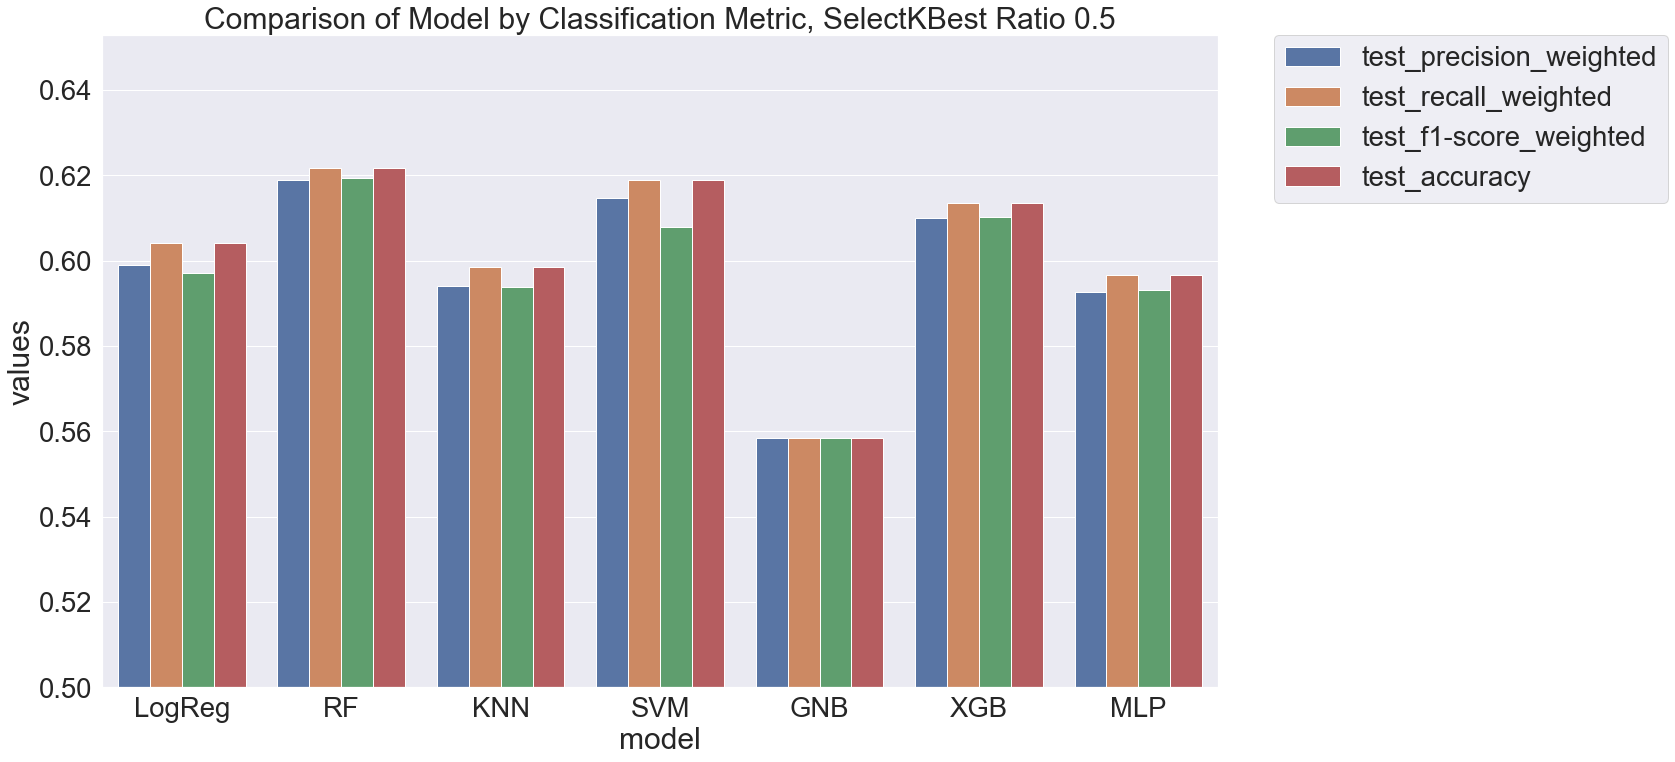

Selected features: Index(['h_age', 'h_f_tr', 'h_ts_percent', 'h_tov_percent', 'h_ft_fga',
       'h_opp_e_fg_percent', 'h_opp_ft_fga', 'h_fga_per_100_poss',
       'h_ft_per_100_poss', 'h_fta_per_100_poss', 'h_tov_per_100_poss',
       'h_pf_per_100_poss', 'a_l', 'a_pl', 'a_mov', 'a_srs', 'a_n_rtg',
       'a_e_fg_percent', 'a_fg_percent', 'a_x2p_percent', 'a_drb_per_100_poss',
       'H_w_pct_10', 'A_w_pct_10', 'H_Team_Elo_Before', 'A_Team_Elo_Before'],
      dtype='object')
Validation results with select ratio of 0.25, 25 features


,model,fit_time,score_time,valid_accuracy,valid_precision_weighted,valid_recall_weighted,valid_f1_weighted
0,GNB,0.006422,0.020065,0.632438,0.632593,0.632438,0.632433
1,KNN,0.004023,0.215246,0.607539,0.604760,0.607539,0.605243
2,LogReg,0.157283,0.023180,0.645195,0.641990,0.645195,0.638412
3,MLP,19.331767,0.009505,0.596953,0.595207,0.596953,0.595722
4,RF,0.884741,0.108996,0.627137,0.624815,0.627137,0.624928
5,SVM,0.273170,0.138649,0.639907,0.636813,0.639907,0.629513
6,XGB,0.191120,0.007052,0.610329,0.608117,0.610329,0.608400


Test results with select ratio of 0.25, 25 features


,test_precision_weighted,test_recall_weighted,test_f1-score_weighted,support,test_accuracy,model
0,0.602838,0.607843,0.600571,1071,0.607843,LogReg
1,0.606437,0.609711,0.606845,1071,0.609711,RF
2,0.590318,0.594771,0.590410,1071,0.594771,KNN
3,0.612676,0.617180,0.607183,1071,0.617180,SVM
4,0.572479,0.573296,0.572847,1071,0.573296,GNB
5,0.610499,0.612512,0.611116,1071,0.612512,XGB
6,0.610774,0.613445,0.611336,1071,0.613445,MLP


c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

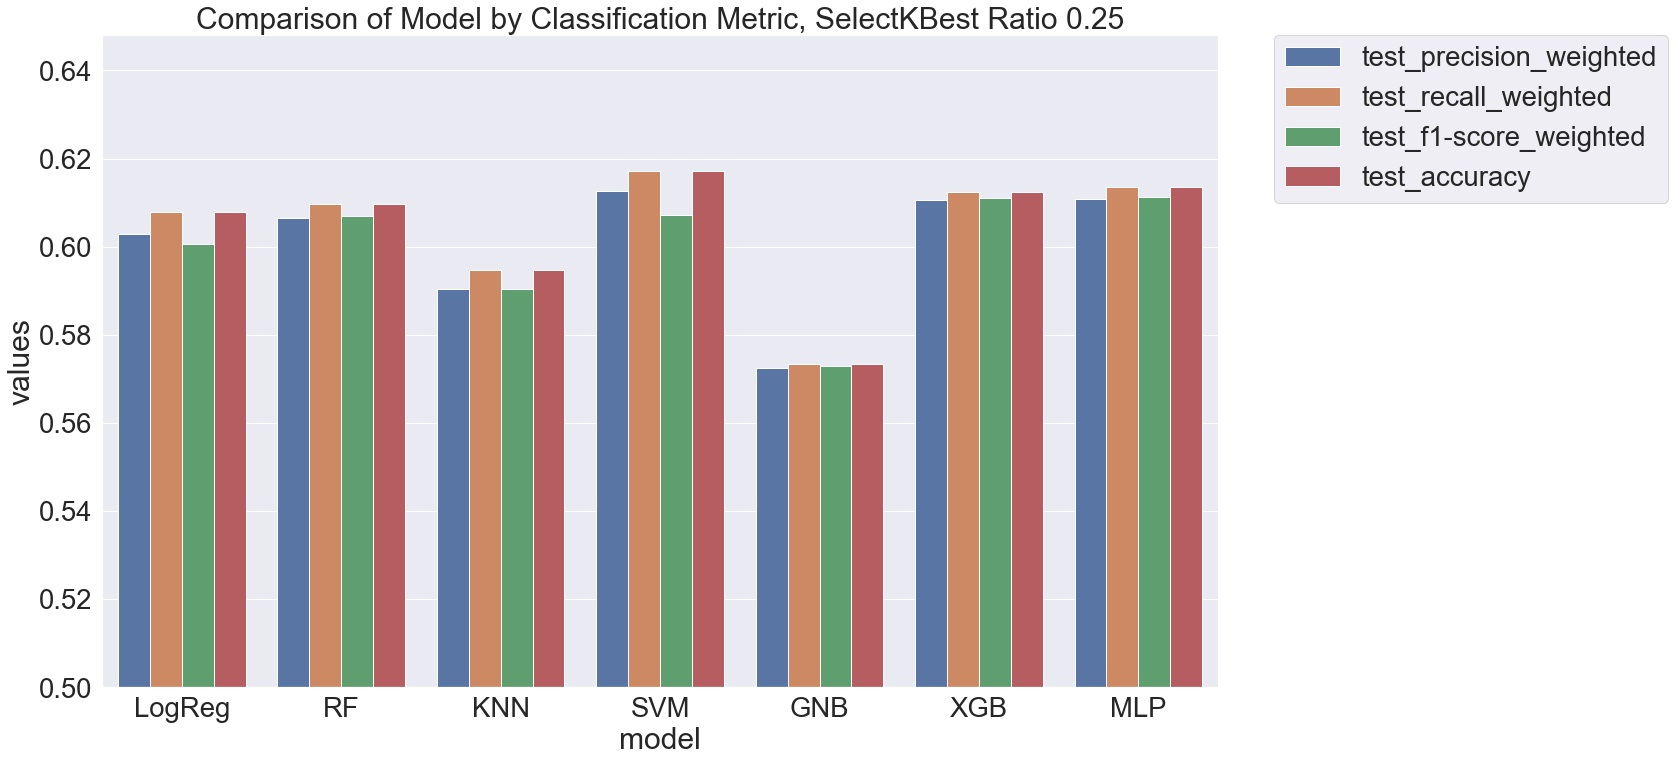

Selected features: Index(['h_age', 'h_f_tr', 'h_tov_percent', 'h_opp_ft_fga',
       'h_fga_per_100_poss', 'h_tov_per_100_poss', 'H_w_pct_10', 'A_w_pct_10',
       'H_Team_Elo_Before', 'A_Team_Elo_Before'],
      dtype='object')
Validation results with select ratio of 0.1, 10 features


,model,fit_time,score_time,valid_accuracy,valid_precision_weighted,valid_recall_weighted,valid_f1_weighted
0,GNB,0.009079,0.019976,0.640533,0.638628,0.640533,0.638462
1,KNN,0.012059,0.141781,0.622165,0.619524,0.622165,0.619452
2,LogReg,0.075030,0.019883,0.653599,0.651058,0.653599,0.646752
3,MLP,17.848835,0.012275,0.618429,0.614935,0.618429,0.614724
4,RF,0.766598,0.108303,0.630881,0.628402,0.630881,0.628717
5,SVM,0.323577,0.133852,0.645198,0.642850,0.645198,0.634304
6,XGB,0.123137,0.012060,0.614689,0.611891,0.614689,0.612437


Test results with select ratio of 0.1, 10 features


,test_precision_weighted,test_recall_weighted,test_f1-score_weighted,support,test_accuracy,model
0,0.608784,0.613445,0.606500,1071,0.613445,LogReg
1,0.595019,0.598506,0.595558,1071,0.598506,RF
2,0.578253,0.582633,0.578791,1071,0.582633,KNN
3,0.601720,0.606909,0.598802,1071,0.606909,SVM
4,0.585430,0.588235,0.586206,1071,0.588235,GNB
5,0.607653,0.610644,0.608162,1071,0.610644,XGB
6,0.612644,0.617180,0.609400,1071,0.617180,MLP


c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

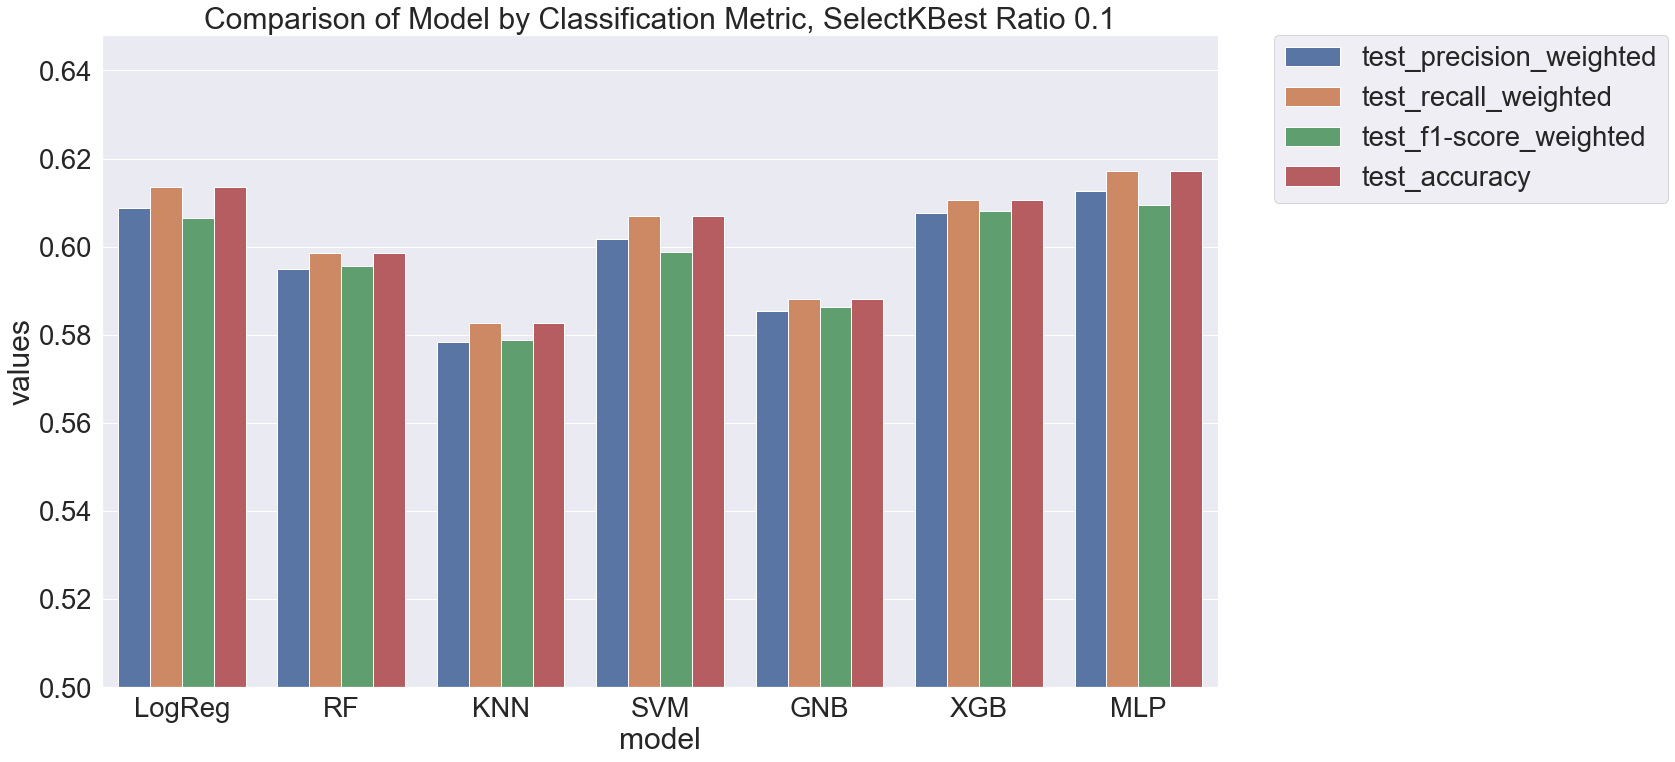

In [107]:
for result in select_results:
    vdf, tdf, select_ratio, n_features, select_indices = result[0][0], result[0][1], result[1], result[2], result[3]

    # Get the names of the selected features
    feature_names = X.columns
    select_feature_names = feature_names[select_indices]
    print(f'Selected features: {select_feature_names}')

    print(f'Validation results with select ratio of {select_ratio}, {n_features} features')
    vdf.columns = [col.replace('test_', 'valid_') if col.startswith('test_') else col for col in vdf.columns]
    display(vdf.groupby('model').mean().reset_index())

    print(f'Test results with select ratio of {select_ratio}, {n_features} features')
    for col in ['precision','recall','f1-score']:
        if col in tdf.columns:
            tdf.rename(columns={col: 'test_' + col + '_weighted'}, inplace=True)
    tdf.rename(columns={'accuracy': 'test_accuracy'}, inplace=True)
    display(tdf)

    generate_bar_graph('SelectKBest',select_ratio,tdf.drop(columns=['support']))

Inspect and visualize results.

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_models(df):
    results_long = pd.melt(df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] # fit time metrics

    ## PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
    results_long_nofit = results_long_nofit.sort_values(by='values')

    ## TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
    results_long_fit = results_long_fit.sort_values(by='values')

    metrics = list(set(results_long_nofit.metrics.values))
    df.groupby(['model'])[metrics].agg([np.std, np.mean])

    return results_long_nofit, results_long_fit

    
def generate_plots(method, ratio, results_long_nofit, results_long_fit):
    title_metric = f'Comparison of Model by Classification Metric, {method} Ratio {ratio}'
    title_time = f'Comparison of Model by Fit and Score Time, {method} Ratio {ratio}'

    # Generate plot comparing models' classification metrics
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_metric)
    plt.savefig(f'plots/{method}_{ratio}_valid.png',dpi=300)
    plt.show()
    
    # Generate plot comparing models' fit and score time
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_time)
    plt.savefig(f'plots/{method}_{ratio}_time.png',dpi=300)
    plt.show()

C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function mean at 0x000001EED1928D30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

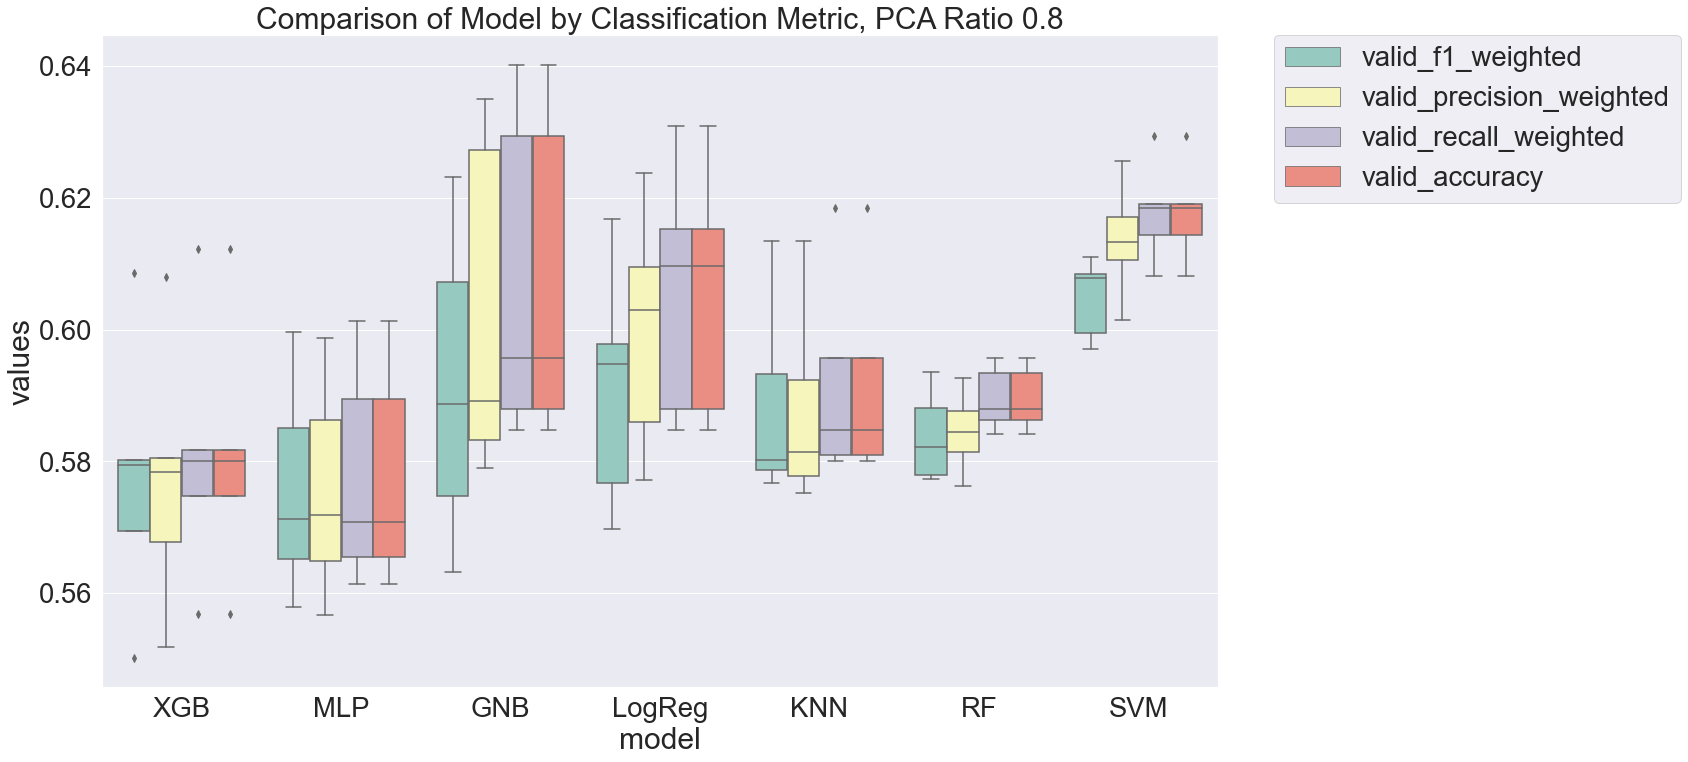

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

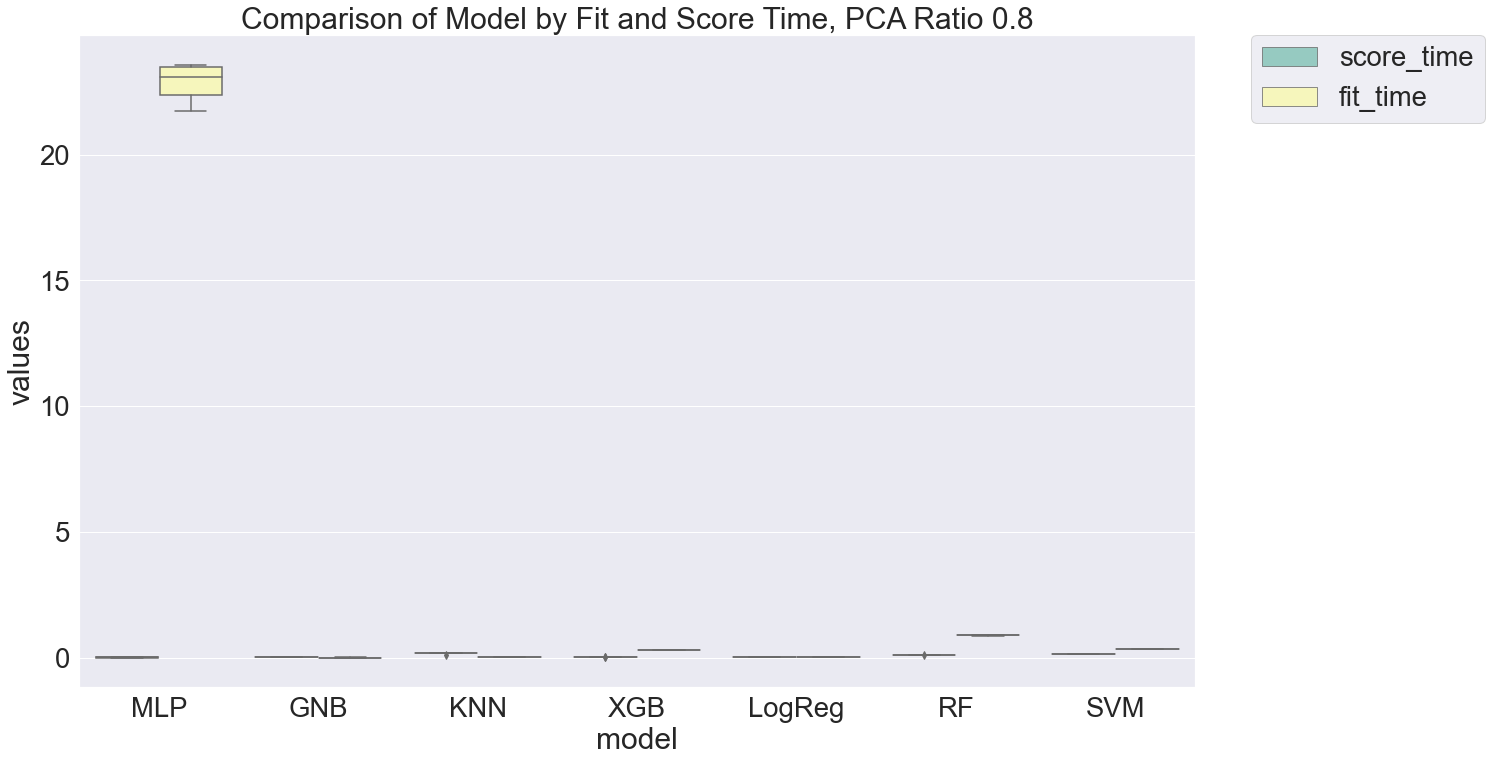

C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function mean at 0x000001EED1928D30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

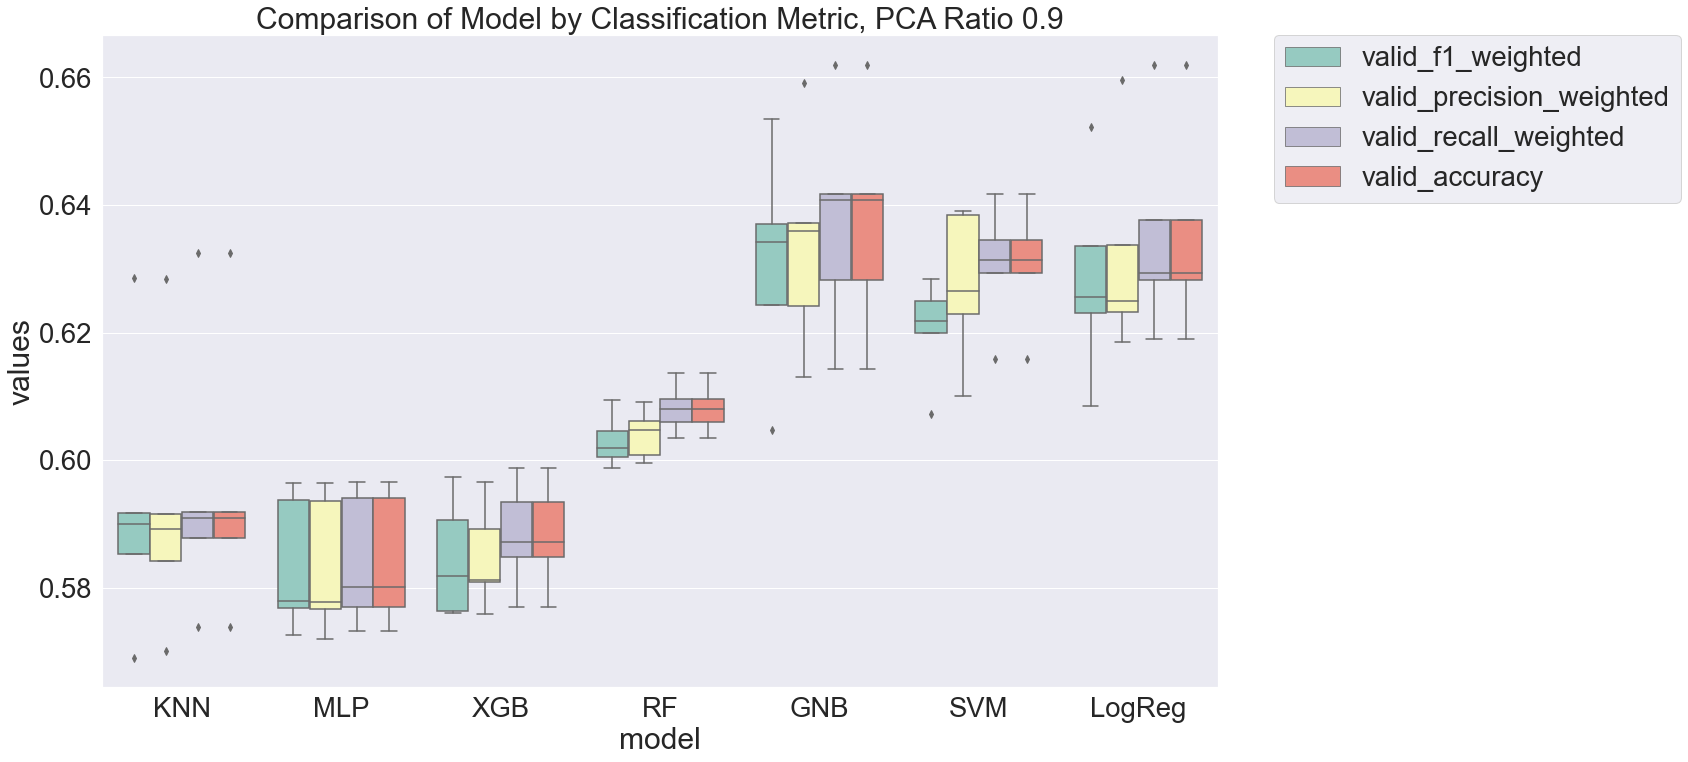

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

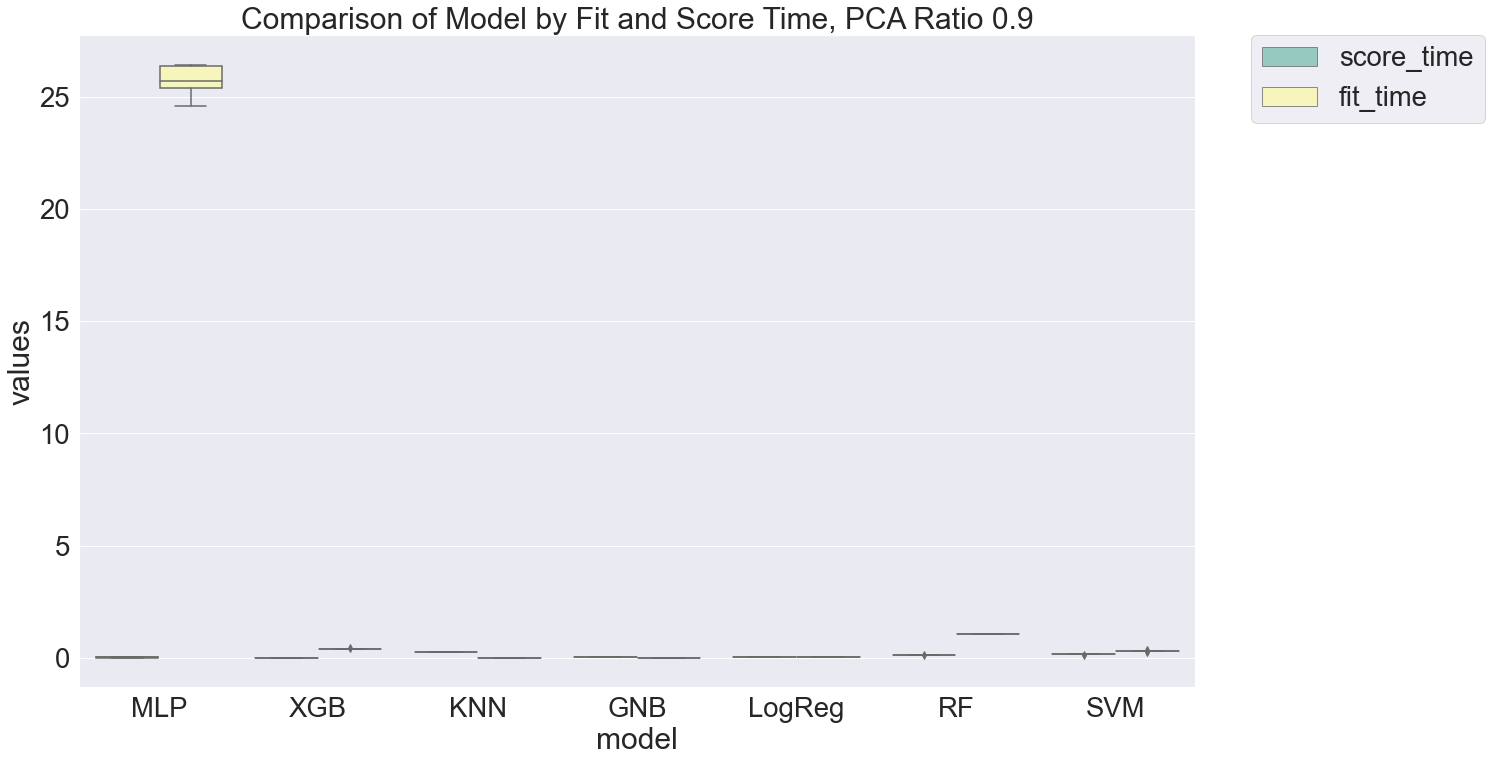

C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function mean at 0x000001EED1928D30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

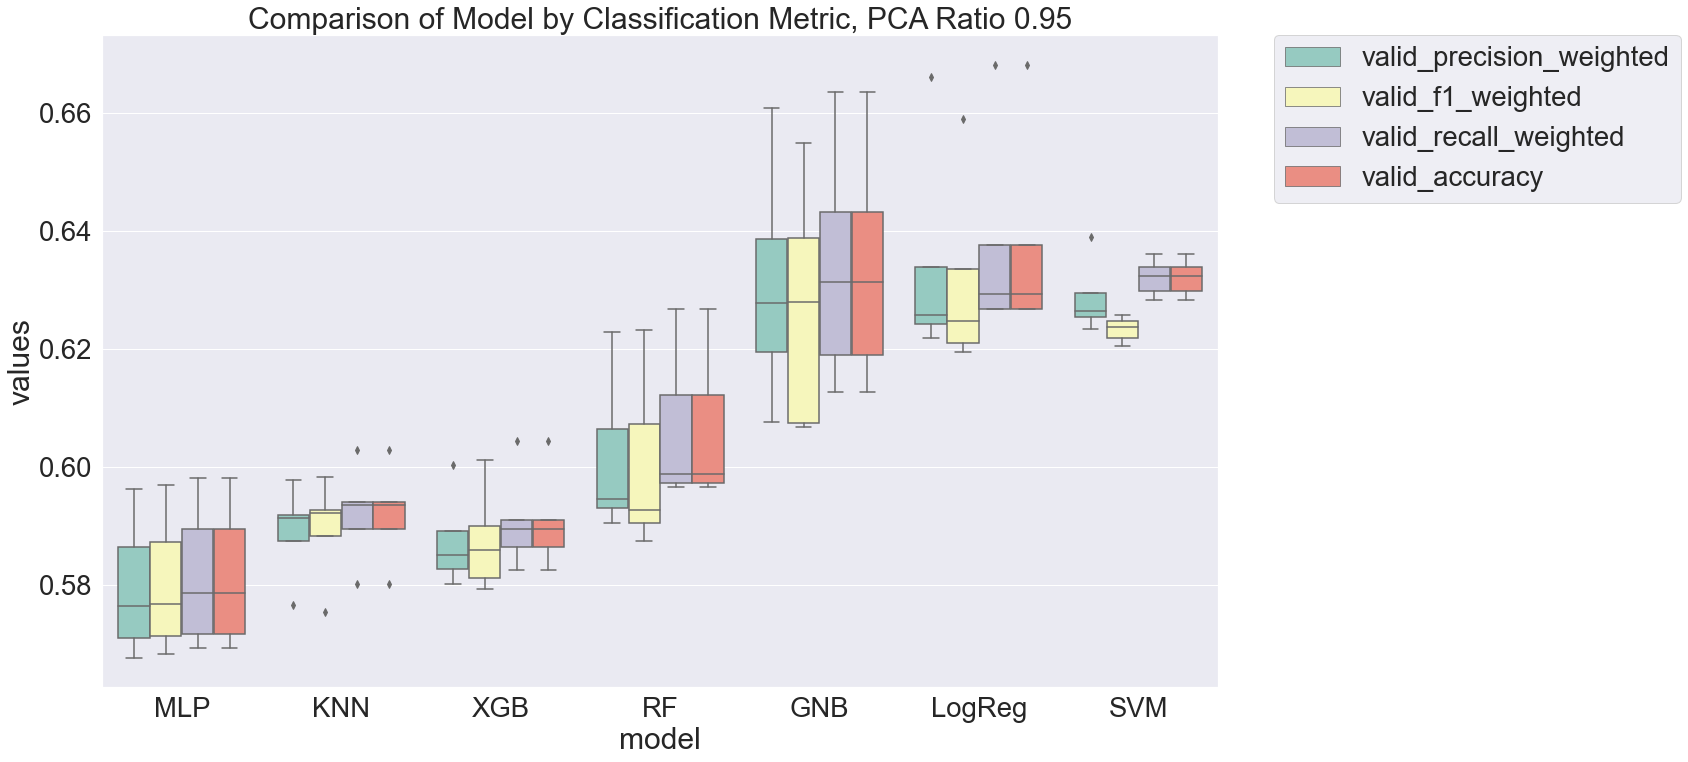

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

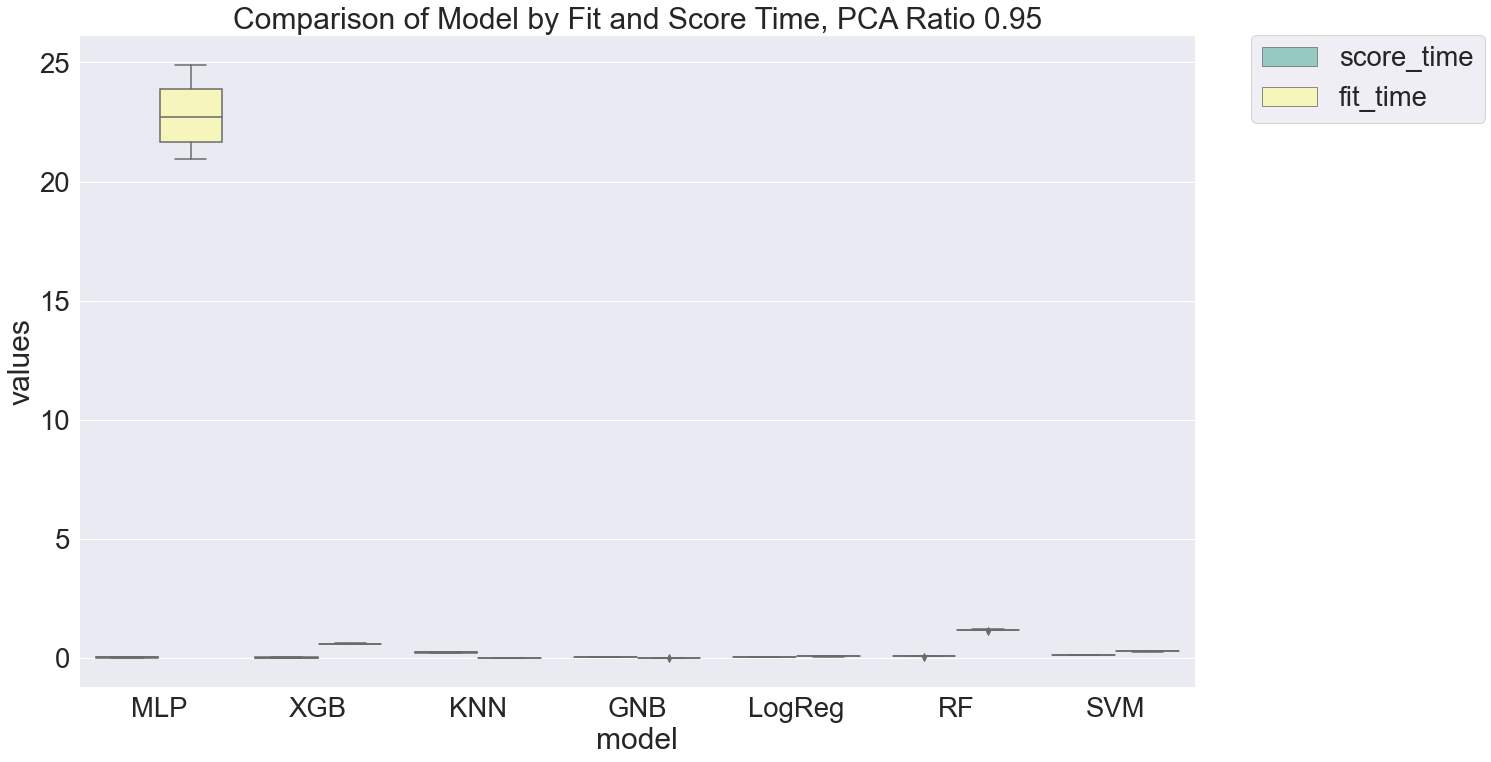

In [109]:
# display results of PCA
for result in pca_results:  
    vdf = result[0][0]
    pca_ratio = result[1]
    method = 'PCA'
    results_long_nofit, results_long_fit = evaluate_models(vdf)
    # n_features = result.shape[1] - len(['model', 'fit_time', 'score_time'])
    generate_plots(method, pca_ratio, results_long_nofit, results_long_fit)

C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function mean at 0x000001EED1928D30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

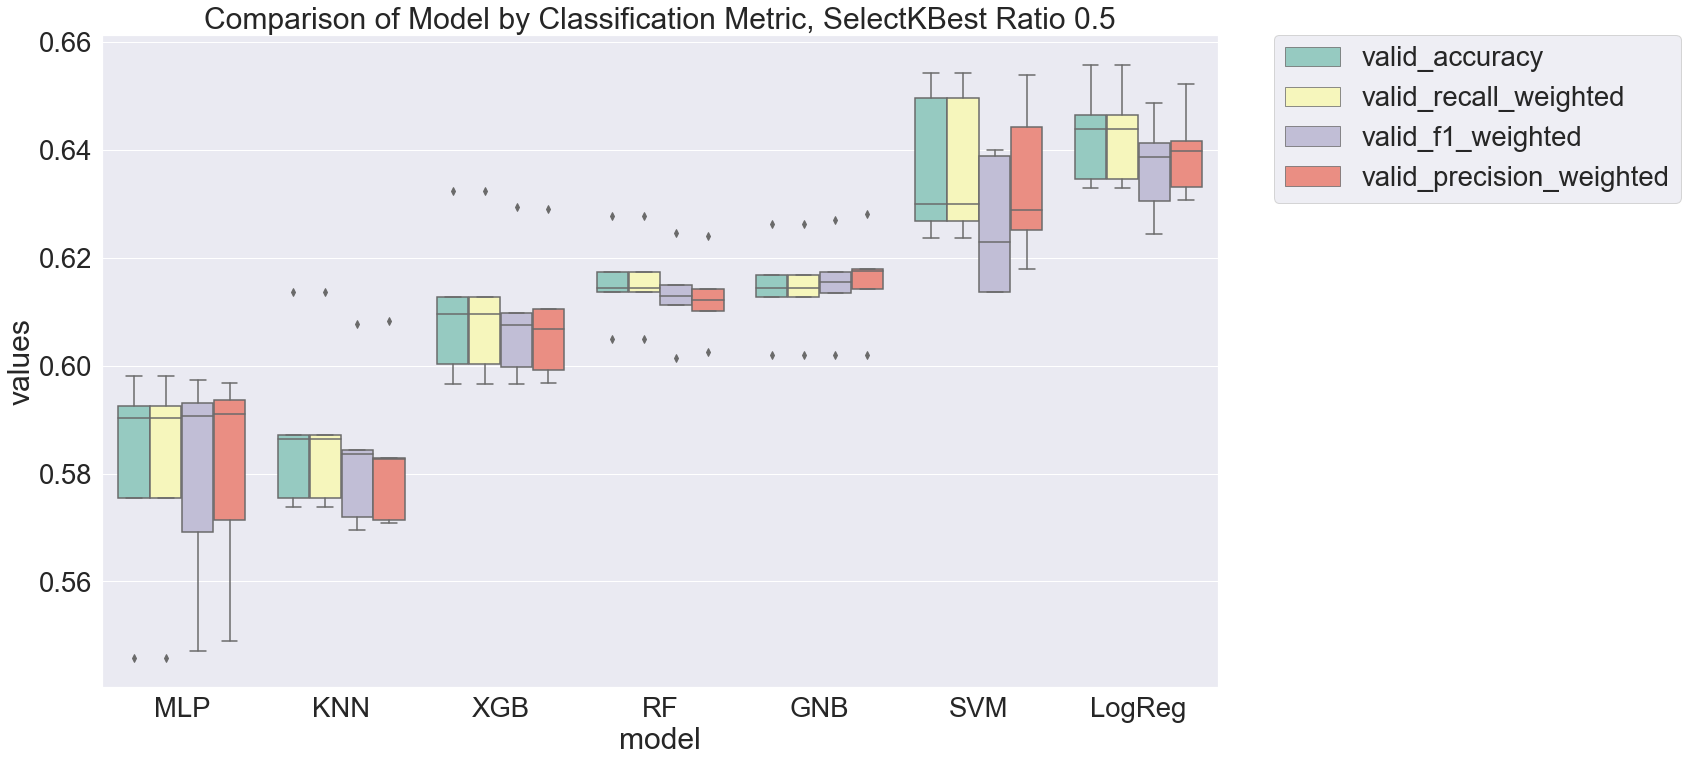

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

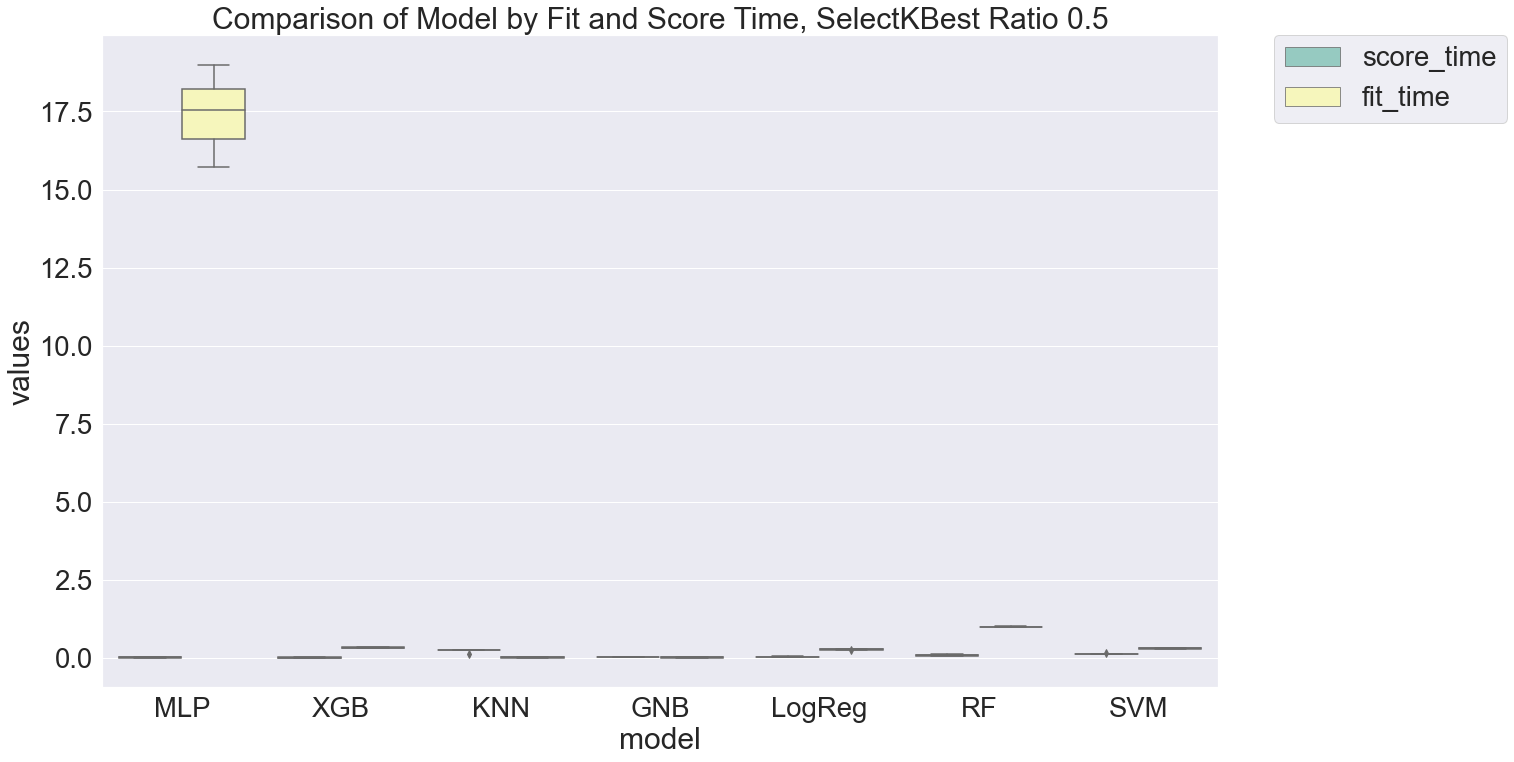

C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function mean at 0x000001EED1928D30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

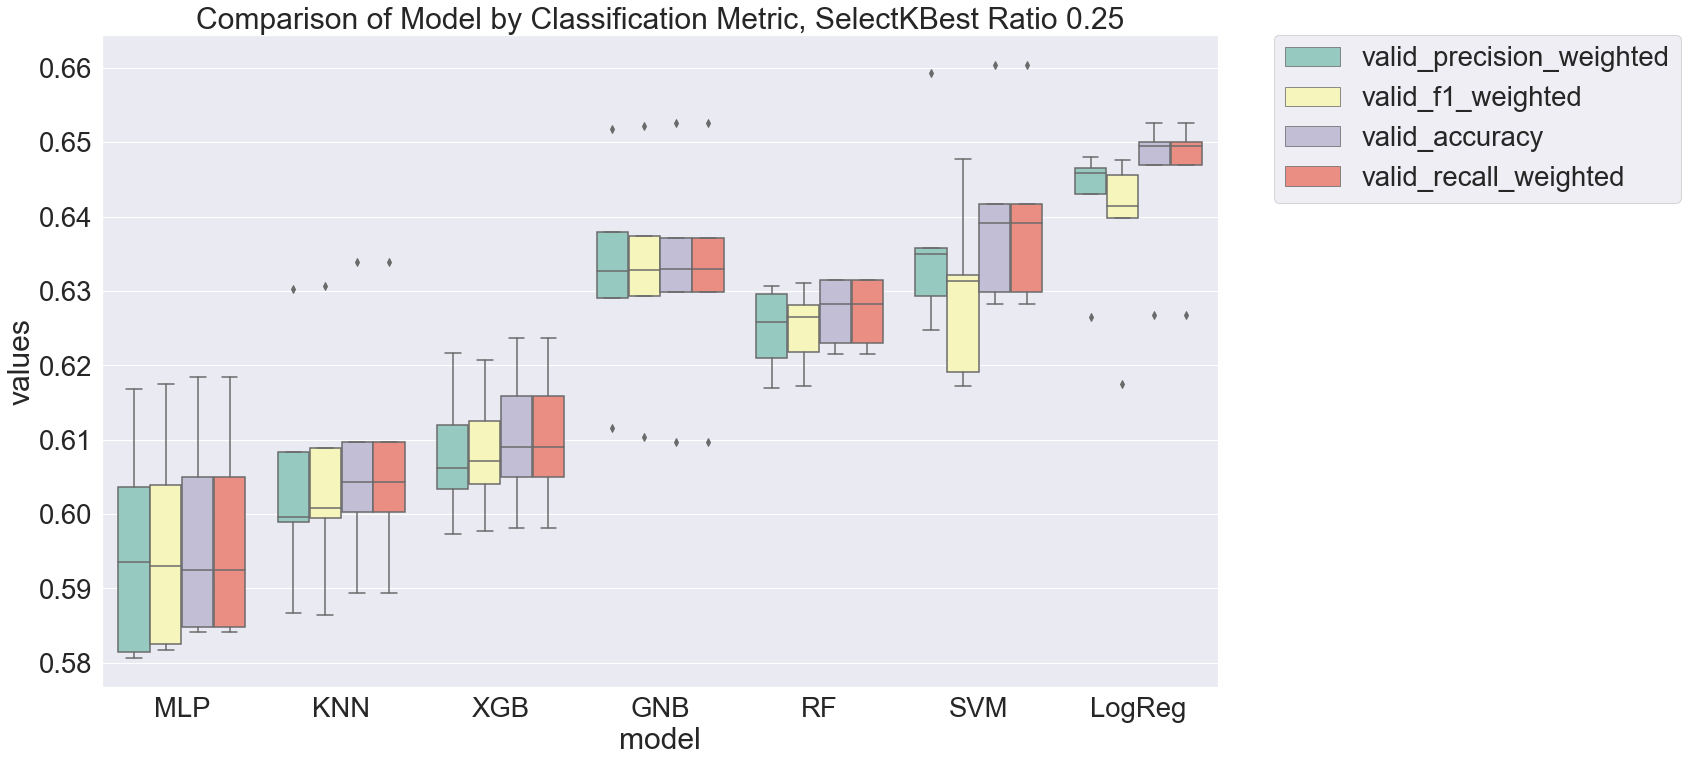

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

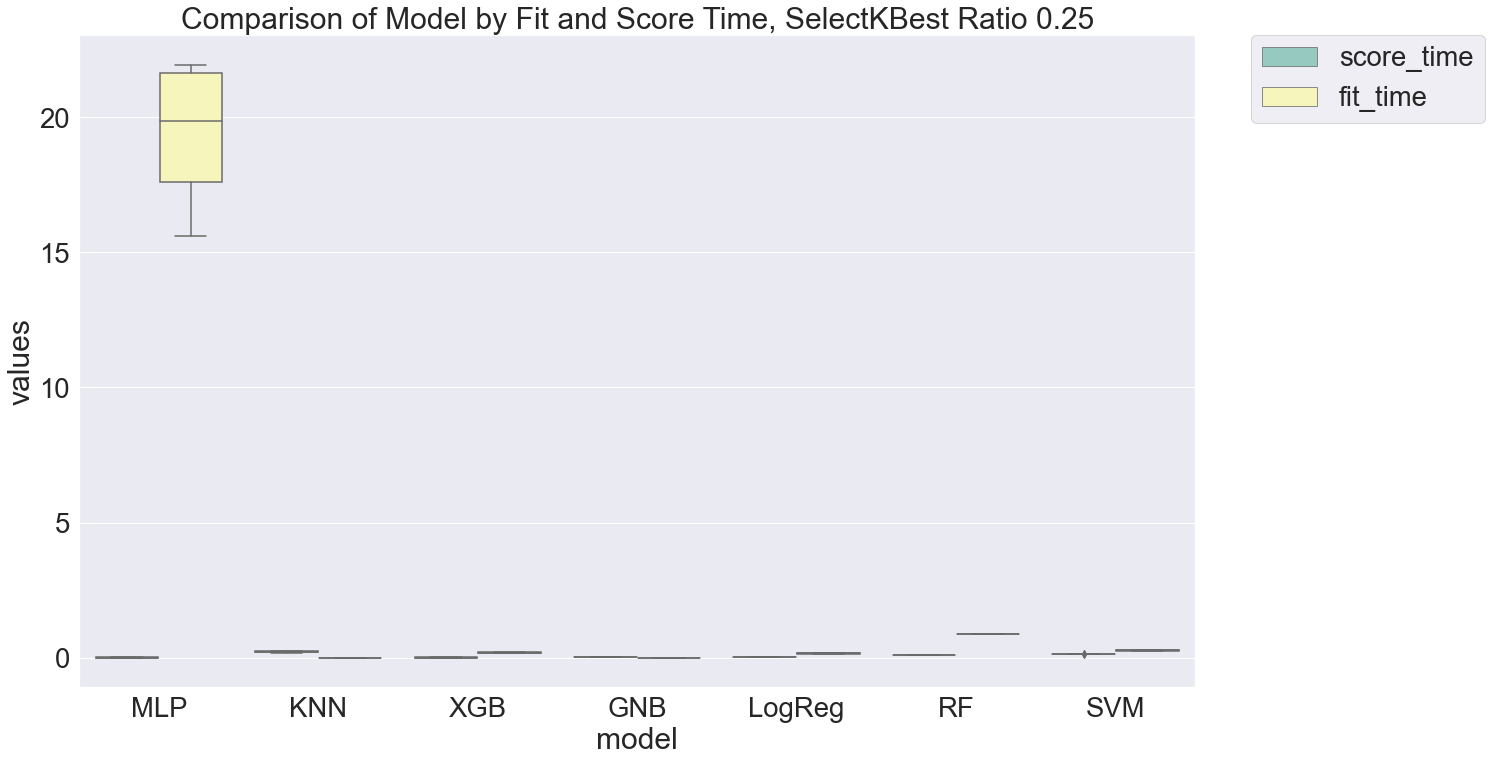

C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function mean at 0x000001EED1928D30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\1456146138.py:17: FutureWarning: The provided callable <function std at 0x000001EED1928EE0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

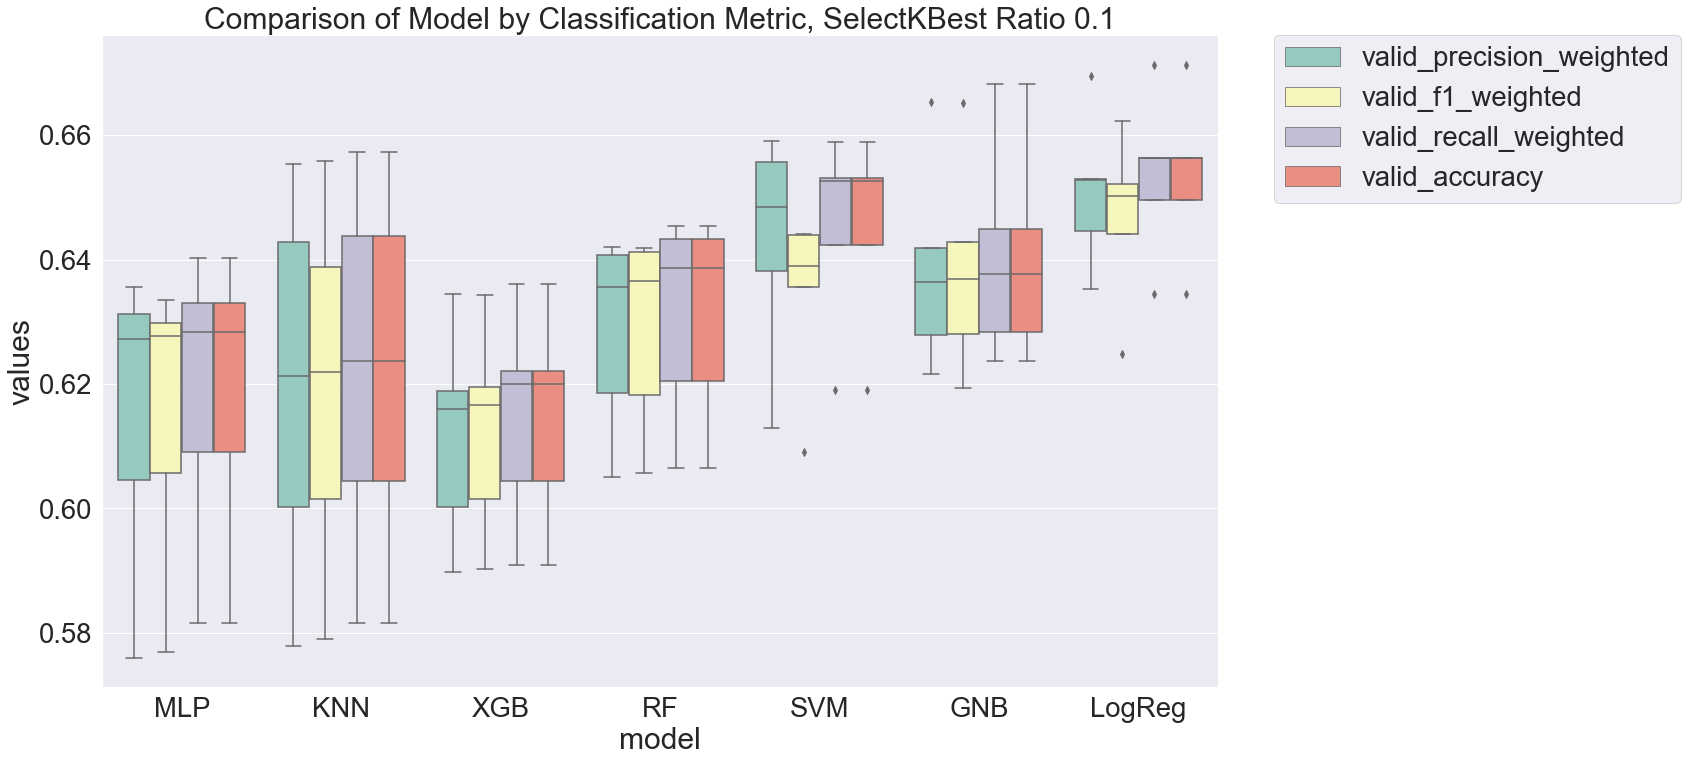

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

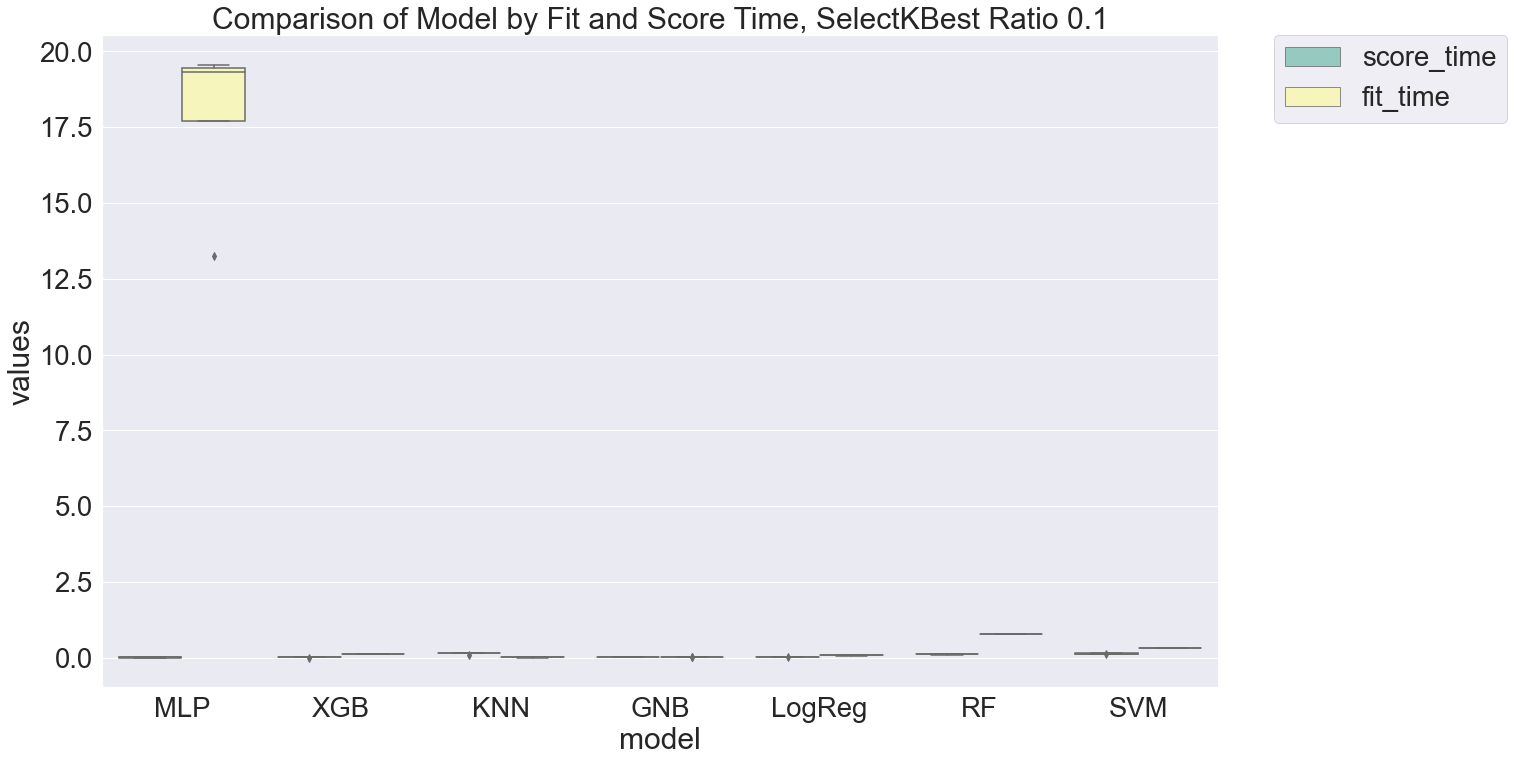

In [110]:
# display results of SelectKBest
for result in select_results:  
    vdf = result[0][0]
    select_ratio = result[1]
    method = 'SelectKBest'
    results_long_nofit, results_long_fit = evaluate_models(vdf)
    # n_features = result.shape[1] - len(['model', 'fit_time', 'score_time'])
    generate_plots(method, select_ratio, results_long_nofit, results_long_fit)

Exploratory Data Analysis

C:\Users\ethan\AppData\Local\Temp\ipykernel_28264\3148213657.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df['HOME_TEAM_WINS'] = y


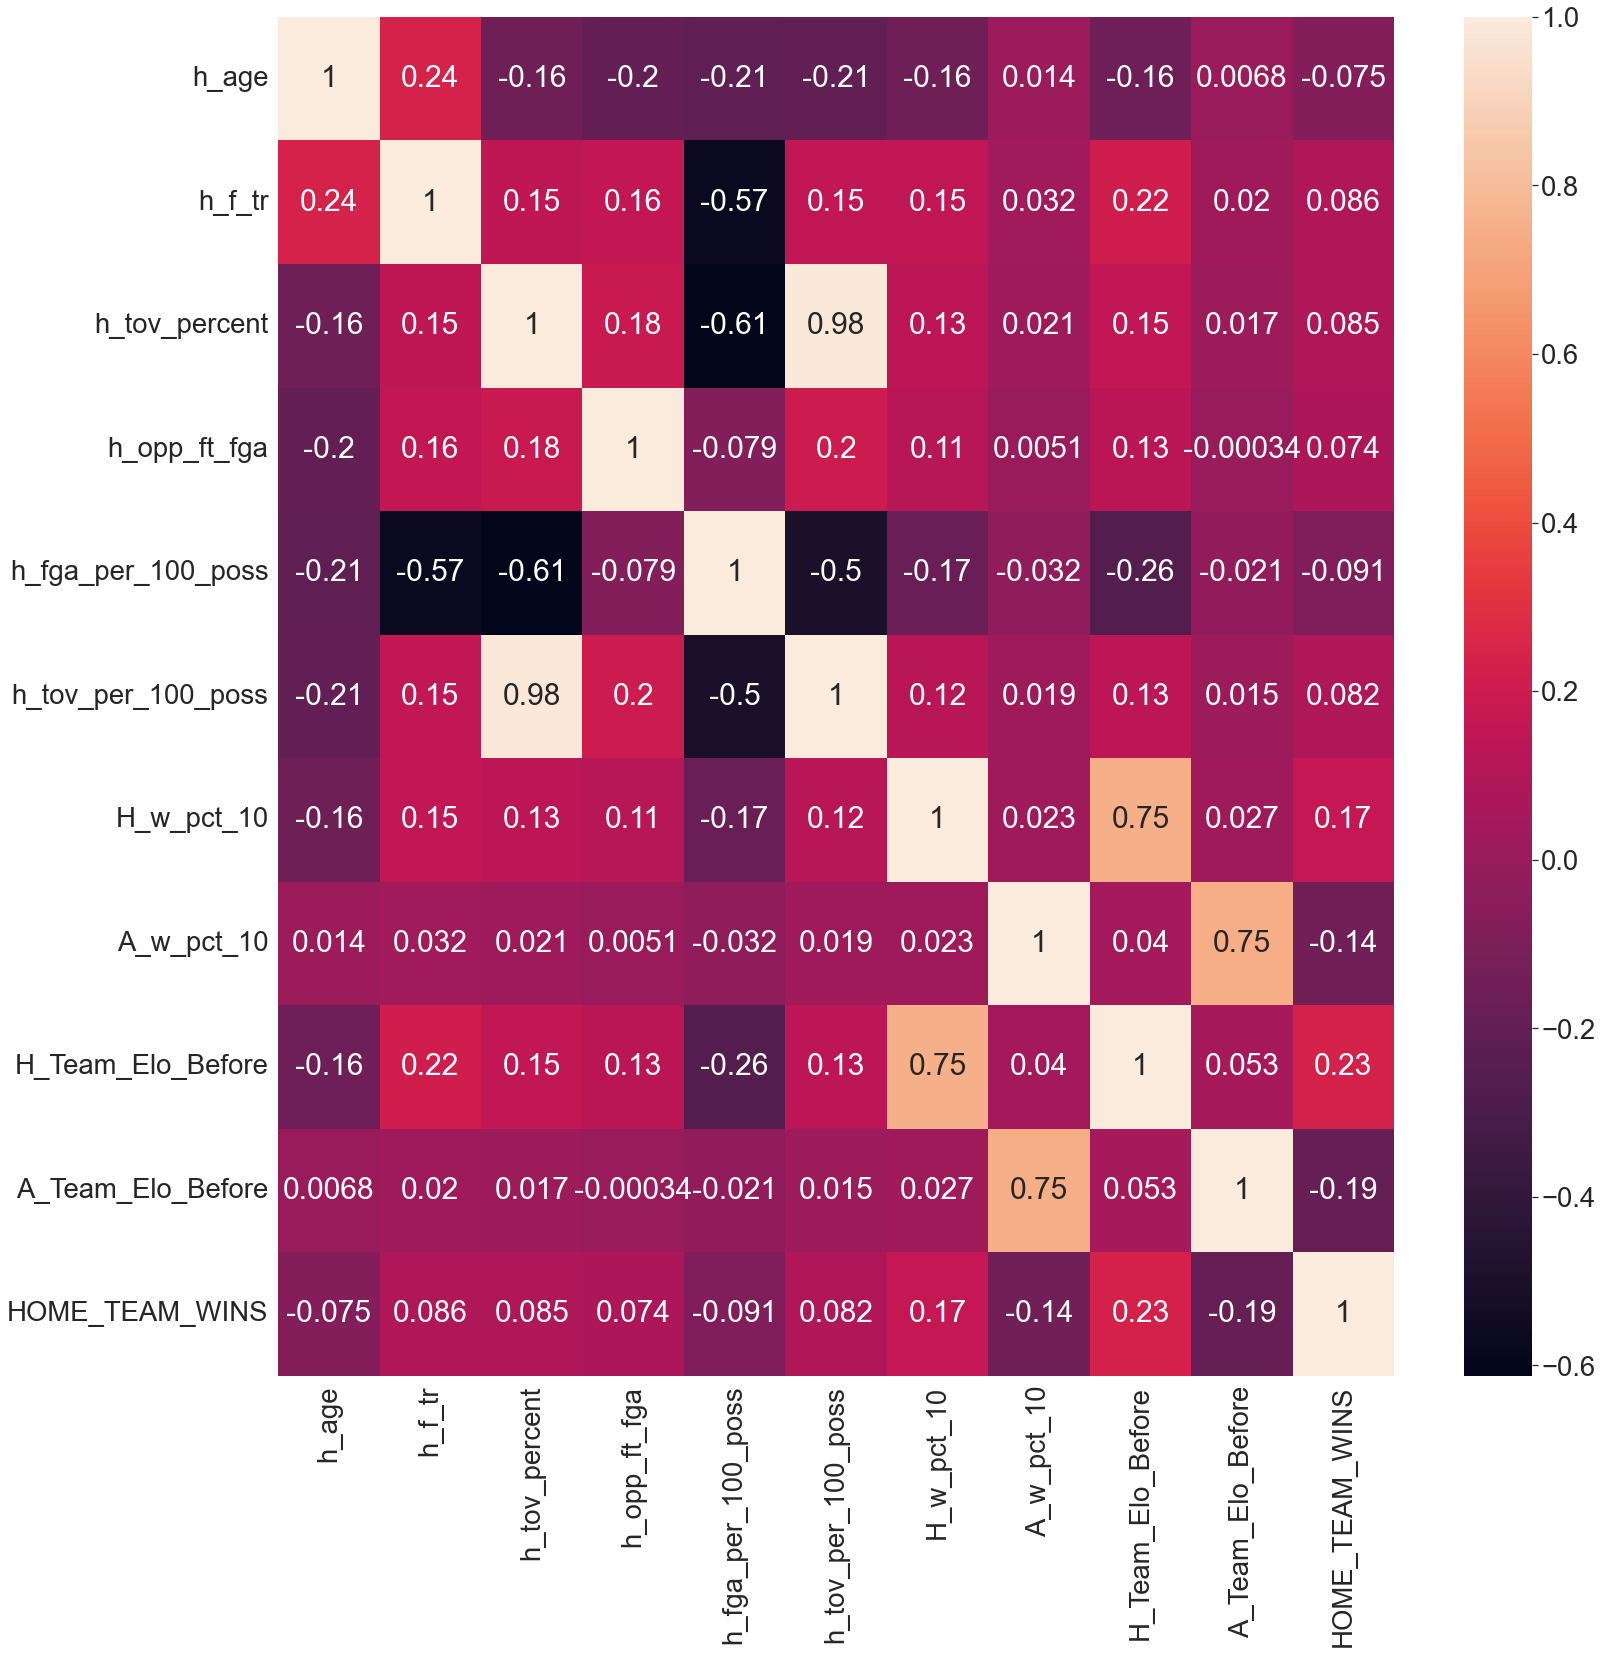

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

def eda(df):
    plt.figure(figsize=(25, 25))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True)
    plt.savefig(f'plots/corr_mat.png',dpi=300)
    plt.show()

eda_df = X[select_feature_names]
eda_df['HOME_TEAM_WINS'] = y
eda(eda_df)